# prep

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
import os
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [148]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.head()

# meta = data_info[(data_info.paradigm == 'grating') & ((data_info.area == 'LM') | (data_info.area == 'LI'))]
meta = data_info[(data_info.paradigm == 'grating') & (data_info.area == 'LM')]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta.tail()

LM    23
Name: area, dtype: int64 23


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
18,1373,230302,LM,200.0,3,1.0,NaN,grating,6s,NaN,NaN
19,1373,230302,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN
20,1381,230307,LM,200.0,2,1.0,NaN,grating,6s,NaN,NaN
21,1381,230307,LM,200.0,3,1.0,NaN,grating,6s,NaN,NaN
22,1381,230307,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN


# df tidy for 1 set
grat 8ori 3isi

In [95]:
iset = 20

mouse = meta.loc[iset, 'mouse'].astype(str)
date = meta.loc[iset, 'date'].astype(str)
area = meta.loc[iset, 'area']
sess = '00' + meta.loc[iset, 'num'].astype(str)
print(mouse, date, area, sess)

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
for dirname in os.listdir(dir_data):
    if mouse in dirname and date in dirname and area in dirname and sess in dirname:
        dir_data = dir_data + dirname
        break

stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

1381 230307 LM 002
ncell: 87, nstim: 1, ntrial: 500, nframe: 207


(dict_keys(['stim_ori', 'isi_nframe', 'adapter_contrast']), (87, 500, 207))

trace_cell_avg: (207,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (207,)


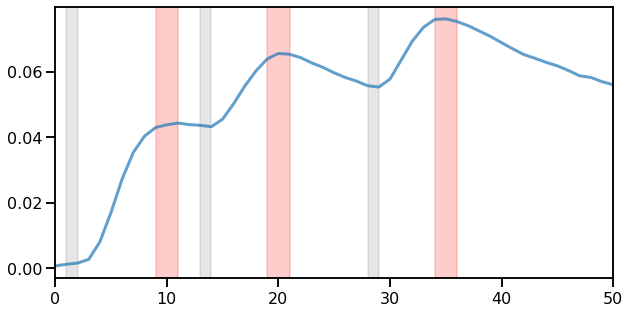

In [ ]:
## find resp window. TODO: auto detect
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

base1_frame = 1
resp_ad_frame = 9
base2_frame = 13
resp_tg250_frame = 19
base3_frame = 28
resp_tg750_frame = 34

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell, alpha=0.7, linewidth=3)
ax.axvspan(base1_frame, base1_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_ad_frame, resp_ad_frame+2, alpha=0.2, color='red')
ax.axvspan(base2_frame, base2_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg250_frame, resp_tg250_frame+2, alpha=0.2, color='red')
ax.axvspan(base3_frame, base3_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg750_frame, resp_tg750_frame+2, alpha=0.2, color='red')
plt.xlim(0, 50);

In [ ]:
## get resp_ad and resp_tg [cell x trial]

base1 = trace_by_trial[:, :, base1_frame : base1_frame+1+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:, :, resp_ad_frame : resp_ad_frame+2+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:, :, base2_frame : base2_frame+1+1].mean(axis=2)
resp_tg250 = trace_by_trial[:, :, resp_tg250_frame : resp_tg250_frame+2+1].mean(axis=2)
resp_tg250 = resp_tg250 - base2

base3 = trace_by_trial[:, :, base3_frame : base3_frame+1+1].mean(axis=2)
resp_tg750 = trace_by_trial[:, :, resp_tg750_frame : resp_tg750_frame+2+1].mean(axis=2)
resp_tg750 = resp_tg750 - base3

resp_ad.shape, resp_tg250.shape, resp_tg750.shape

((87, 500), (87, 500), (87, 500))

In [ ]:
trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]

## stitch resp_tg250 and resp_tg750 together, based on trial_isi_nframe
ntrial = resp_ad.shape[1]
resp_tg = np.zeros_like(resp_ad)
for itrial in range(ntrial):
    resp_tg[:, itrial] = resp_tg250[:, itrial] if trial_isi_nframe[itrial] < 10 else resp_tg750[:, itrial]
# print(np.unique(trial_isi_nframe)) # 10 > 8 frame == 250 ms

R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
R2_dfof = resp_tg.flatten()
dfof = np.hstack((R1_dfof, R2_dfof))

In [ ]:
ncell = resp_ad.shape[0]
ntrial = resp_ad.shape[1]
cell_id = np.repeat(np.arange(ncell), ntrial)
cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

trial_id = np.tile(np.arange(ntrial), ncell)
trial_id = np.hstack((trial_id, trial_id))

len_df = ncell * ntrial * 2 # 2 for (R1, R2)
resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

cell_id.shape, trial_id.shape, dfof.shape, len(resp_id)

((87000,), (87000,), (87000,), 87000)

In [ ]:
## map stim2 orientation to int
trial_stim_orien = [item[0] for item in stim_id['stim_ori']]
print(np.sort(np.unique(trial_stim_orien)))

trial_stim_orien_dict = {}
for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
    trial_stim_orien_dict[item] = i
trial_stim_orien_dict

trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]


In [ ]:
trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
trial_isi_nframe = trial_isi_nframe[:ntrial]
trial_adapter_contrast = trial_adapter_contrast[:ntrial]

stim_id_col = np.tile(trial_stim_orien_int, ncell)
isi_col = np.tile(trial_isi_nframe, ncell)
ad_con_col = np.tile(trial_adapter_contrast, ncell)
stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
adapter_id_col = np.zeros_like(stim_id_col)
isi_col = np.hstack((isi_col, isi_col))
ad_con_col = np.hstack((ad_con_col, ad_con_col))

stim_id_col.shape, isi_col.shape, ad_con_col.shape, adapter_id_col.shape

((87000,), (87000,), (87000,), (87000,))

In [ ]:
df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                        'isi': isi_col, 'stim1_contrast': ad_con_col, 
                        'stim2_id': stim_id_col, 'stim1_id': adapter_id_col,})
df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id
0,0.399759,0,0,R1,8,1,3,0
1,0.027992,0,3,R1,23,1,6,0
2,0.054808,0,6,R1,8,1,3,0
3,0.029828,0,8,R1,23,1,5,0
4,-0.012044,0,11,R1,23,1,2,0
...,...,...,...,...,...,...,...,...
74293,0.011308,86,495,R2,23,1,2,0
74294,-0.008860,86,496,R2,23,1,7,0
74295,-0.039800,86,497,R2,8,1,2,0
74296,-0.011214,86,498,R2,8,1,5,0


In [ ]:
## vis cell filter & img driven cell-stim filter

df_tidy['filter_cell'] = np.nan
df_tidy['filter_cell_stim'] = np.nan

with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
    filter_file = pickle.load(f)
filter_cell_stim = filter_file['img_driven']
filter_cell = filter_file['vis_driven']

print(f'ncell = {filter_cell_stim.shape[0]}, nstim = {filter_cell_stim.shape[1]}')
for icell in np.arange(filter_cell_stim.shape[0]):
    df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
    for istim in np.arange(filter_cell_stim.shape[1]):
        df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
        
df_tidy
# df_tidy.filter_cell.value_counts(), df_tidy.filter_cell_stim.value_counts()

ncell = 87, nstim = 8


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,filter_cell,filter_cell_stim
0,0.399759,0,0,R1,8,1,3,0,False,False
1,0.027992,0,3,R1,23,1,6,0,False,False
2,0.054808,0,6,R1,8,1,3,0,False,False
3,0.029828,0,8,R1,23,1,5,0,False,False
4,-0.012044,0,11,R1,23,1,2,0,False,False
...,...,...,...,...,...,...,...,...,...,...
74293,0.011308,86,495,R2,23,1,2,0,True,False
74294,-0.008860,86,496,R2,23,1,7,0,True,False
74295,-0.039800,86,497,R2,8,1,2,0,True,False
74296,-0.011214,86,498,R2,8,1,5,0,True,False


# df tidy for n set

## find resp window

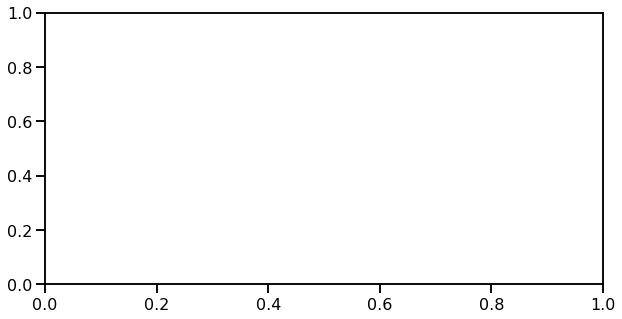

In [130]:
trace_avg_cell_set = []
for iset in range(nset):

    mouse = meta.loc[iset, 'mouse'].astype(str)
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(mouse, date, area, sess)

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(dir_data):
        if mouse in dirname and date in dirname and area in dirname and sess in dirname:
            dir_data = dir_data + dirname
            break

    stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
    stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

    trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)
    trace_avg_cell_set.append(trace_avg_cell)

trace_avg_cell_set = np.array(trace_avg_cell_set)

from IPython.display import clear_output
clear_output()

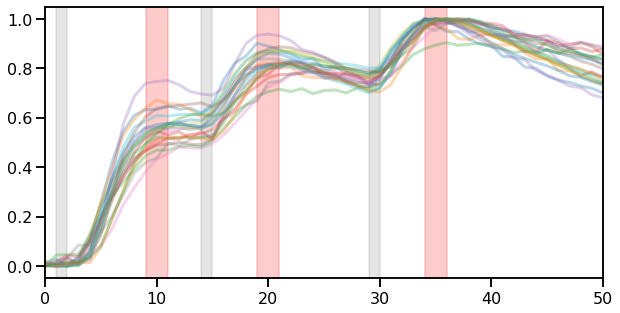

In [135]:
base1_frame = 1
resp_ad_frame = 9
base2_frame = 14
resp_tg250_frame = 19
base3_frame = 29
resp_tg750_frame = 34

fig, ax = plt.subplots(figsize=(10, 5))
for iset in range(nset):
    trace_now = trace_avg_cell_set[iset]
    # max min normalization
    trace_now = (trace_now - np.min(trace_now) ) / (np.max(trace_now) - np.min(trace_now))
    plt.plot(trace_now, alpha=0.3, linewidth=3)

ax.axvspan(base1_frame, base1_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_ad_frame, resp_ad_frame+2, alpha=0.2, color='red')
ax.axvspan(base2_frame, base2_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg250_frame, resp_tg250_frame+2, alpha=0.2, color='red')
ax.axvspan(base3_frame, base3_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg750_frame, resp_tg750_frame+2, alpha=0.2, color='red')

plt.xlim(0, 50);

## batch write df_tidy

In [137]:
for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(mouse, date, area, sess)

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(dir_data):
        if mouse in dirname and date in dirname and area in dirname and sess in dirname:
            dir_data = dir_data + dirname
            break

    stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
    stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

    ## slice by resp window, determined by section above
    base1_frame = 1
    resp_ad_frame = 9
    base2_frame = 14
    resp_tg250_frame = 19
    base3_frame = 29
    resp_tg750_frame = 34

    ## get resp_ad and resp_tg [cell x trial]
    base1 = trace_by_trial[:, :, base1_frame : base1_frame+1+1].mean(axis=2) # avg over time window frames
    resp_ad = trace_by_trial[:, :, resp_ad_frame : resp_ad_frame+2+1].mean(axis=2)
    resp_ad = resp_ad - base1

    base2 = trace_by_trial[:, :, base2_frame : base2_frame+1+1].mean(axis=2)
    resp_tg250 = trace_by_trial[:, :, resp_tg250_frame : resp_tg250_frame+2+1].mean(axis=2)
    resp_tg250 = resp_tg250 - base2

    base3 = trace_by_trial[:, :, base3_frame : base3_frame+1+1].mean(axis=2)
    resp_tg750 = trace_by_trial[:, :, resp_tg750_frame : resp_tg750_frame+2+1].mean(axis=2)
    resp_tg750 = resp_tg750 - base3

    ## construct dfof
    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    ntrial = resp_ad.shape[1]
    resp_tg = np.zeros_like(resp_ad)
    for itrial in range(ntrial): # stitch resp_tg250 and resp_tg750 together, based on trial_isi_nframe
        resp_tg[:, itrial] = resp_tg250[:, itrial] if trial_isi_nframe[itrial] < 10 else resp_tg750[:, itrial]
    # print(np.unique(trial_isi_nframe)) # NOTE 10 > 8 frame == 250 ms

    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof))

    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial)
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

    trial_id = np.tile(np.arange(ntrial), ncell)
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

    ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
    trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
    trial_stim_orien_dict = {} ## map stim2 orientation to int
    for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
        trial_stim_orien_dict[item] = i
    trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

    trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
    trial_isi_nframe = trial_isi_nframe[:ntrial]
    trial_adapter_contrast = trial_adapter_contrast[:ntrial]

    stim_id_col = np.tile(trial_stim_orien_int, ncell)
    isi_col = np.tile(trial_isi_nframe, ncell)
    ad_con_col = np.tile(trial_adapter_contrast, ncell)

    stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
    adapter_id_col = np.zeros_like(stim_id_col) # adapter (stim1) is always 0 deg / vertical gratings
    isi_col = np.hstack((isi_col, isi_col))
    ad_con_col = np.hstack((ad_con_col, ad_con_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                            'isi': isi_col, 'stim1_contrast': ad_con_col, 
                            'stim2_id': stim_id_col, 'stim1_id': adapter_id_col,})
    df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
    df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

    ## vis cell filter & img driven cell-stim filter
    df_tidy['filter_cell'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell = filter_file['vis_driven']

    # print(f'ncell = {filter_cell_stim.shape[0]}, nstim = {filter_cell_stim.shape[1]}')
    for icell in np.arange(filter_cell_stim.shape[0]):
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell.value_counts(), df_tidy.filter_cell_stim.value_counts()
    
    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy.csv'), index=False)


iset=0, nset=23
1323 200721 LM 002
ncell: 39, nstim: 1, ntrial: 465, nframe: 206
iset=1, nset=23
1324 200729 LM 003
ncell: 52, nstim: 1, ntrial: 464, nframe: 207
iset=2, nset=23
1322 200804 LM 003
ncell: 69, nstim: 1, ntrial: 464, nframe: 206
iset=3, nset=23
1328 201119 LM 003
ncell: 71, nstim: 1, ntrial: 464, nframe: 206
iset=4, nset=23
1328 201127 LM 002
ncell: 40, nstim: 1, ntrial: 463, nframe: 207
iset=5, nset=23
1329 201217 LM 002
ncell: 107, nstim: 1, ntrial: 464, nframe: 206
iset=6, nset=23
1329 201217 LM 004
ncell: 90, nstim: 1, ntrial: 463, nframe: 206
iset=7, nset=23
1337 210127 LM 002
ncell: 86, nstim: 1, ntrial: 464, nframe: 206
iset=8, nset=23
1337 210127 LM 003
ncell: 62, nstim: 1, ntrial: 463, nframe: 206
iset=9, nset=23
1338 210325 LM 002
ncell: 85, nstim: 1, ntrial: 465, nframe: 207
iset=10, nset=23
1338 210805 LM 002
ncell: 80, nstim: 1, ntrial: 463, nframe: 207
iset=11, nset=23
1339 210908 LM 003
ncell: 59, nstim: 1, ntrial: 464, nframe: 207
iset=12, nset=23
1350 211

# batch load df_tidy

In [165]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, 'df_tidy.csv'))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, 'df_tidy.csv'))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms

iset=0, nset=23
i1323 200721 LM 002
iset=1, nset=23
i1324 200729 LM 003
iset=2, nset=23
i1322 200804 LM 003
iset=3, nset=23
i1328 201119 LM 003
iset=4, nset=23
i1328 201127 LM 002
iset=5, nset=23
i1329 201217 LM 002
iset=6, nset=23
i1329 201217 LM 004
iset=7, nset=23
i1337 210127 LM 002
iset=8, nset=23
i1337 210127 LM 003
iset=9, nset=23
i1338 210325 LM 002
iset=10, nset=23
i1338 210805 LM 002
iset=11, nset=23
i1339 210908 LM 003
iset=12, nset=23
i1350 211020 LM 002
iset=13, nset=23
i1350 211020 LM 003
iset=14, nset=23
i1351 220228 LM 002
iset=15, nset=23
i1351 220228 LM 003
iset=16, nset=23
i1380 230221 LM 002
iset=17, nset=23
i1380 230221 LM 003
iset=18, nset=23
i1373 230302 LM 003
iset=19, nset=23
i1373 230302 LM 004
iset=20, nset=23
i1381 230307 LM 002
iset=21, nset=23
i1381 230307 LM 003
iset=22, nset=23
i1381 230307 LM 004


In [175]:
print(df_tidy.mouse.unique(), df_tidy.date.unique(), df_tidy.sess.unique(), 
    df_tidy.isi.unique(), df_tidy.stim1_contrast.unique(), df_tidy.stim2_id.unique(), df_tidy.resp_id.unique())
df_tidy.sample(10)

['1323' '1324' '1322' '1328' '1329' '1337' '1338' '1339' '1350' '1351'
 '1380' '1373' '1381'] ['200721' '200729' '200804' '201119' '201127' '201217' '210127' '210325'
 '210805' '210908' '211020' '220228' '230221' '230302' '230307'] ['002' '003' '004'] [250 750] [1 0] [3 6 5 2 1 4 0 7] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,filter_cell,filter_cell_stim,mouse,date,sess
460106,0.014176,210127_003_8,54,R2,750,1,2,0,True,False,1337,210127,003
444212,-0.015863,210127_003_24,140,R1,750,1,1,0,True,False,1337,210127,003
1156271,0.024680,230302_004_60,191,R2,750,1,6,0,True,True,1373,230302,004
460049,0.036133,210127_003_7,460,R2,250,1,2,0,False,False,1337,210127,003
770826,-0.020789,220228_002_21,191,R1,750,1,6,0,True,False,1351,220228,002
1041494,-0.045240,230302_003_68,330,R2,250,1,4,0,True,True,1373,230302,003
39608,-0.069256,200729_003_26,441,R1,750,1,7,0,False,False,1324,200729,003
1116043,0.076880,230302_004_113,41,R1,750,1,2,0,True,True,1373,230302,004
852232,0.027421,220228_003_33,123,R2,250,1,1,0,False,False,1351,220228,003
985315,0.232079,230302_003_77,246,R1,250,1,1,0,True,True,1373,230302,003


# re_well_fit for cell filter

In [178]:
df_tidy.sample(5)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,filter_cell,filter_cell_stim,mouse,date,sess
286572,-0.005879,201217_002_82,292,R2,250,1,2,0,False,False,1329,201217,002
462808,0.124793,210127_003_13,441,R2,250,1,1,0,True,False,1337,210127,003
1211627,0.004735,230307_002_41,49,R1,250,1,2,0,False,False,1381,230307,002
907328,0.015748,230221_002_27,39,R2,750,1,0,0,True,False,1380,230221,002
273203,-0.016141,201217_002_53,379,R2,250,0,2,0,True,False,1329,201217,002
